# GradCAM - Gradient Class Activation Map

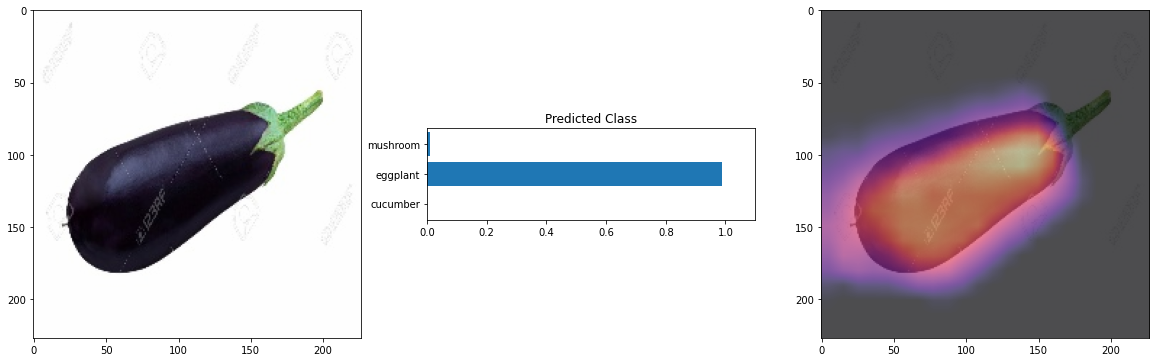

In [ ]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git 
!pip install -U git+https://github.com/albumentations-team/albumentations 
!pip install --upgrade opencv-contrib-python 

fatal: destination path 'GradCAM-Dataset' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-dmyuxni5
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-dmyuxni5
  Resolved https://github.com/albumentations-team/albumentations to commit cb372736a0b7da362e5c2e23f3cce4304ddac402
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import sys 
sys.path.append('/content/GradCAM-Dataset')

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

import torch 
from torch import nn 
import torch.nn.functional as F 

from torch.utils.data import DataLoader, Dataset 
from torchvision import datasets, transforms as T

from tqdm import tqdm 
import albumentations as A 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [ ]:
CSV_FILE= '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'
DEVICE = 'cuda'
BATCH_SIZE =16
LR = 0.001
EPOCHS =20

In [ ]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [ ]:
train_df , valid_df = train_test_split(data,test_size= 0.2, random_state= 42)

# Augmentations

In [ ]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p = 0.5),
    A.Normalize (mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])

valid_augs = A.Compose([
        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
                      

# Load Image Dataset 

In [ ]:
trainset =utils.ImageDataset(train_df, augs= train_augs, data_dir=DATA_DIR)
validset =utils.ImageDataset(valid_df, augs= valid_augs, data_dir=DATA_DIR)

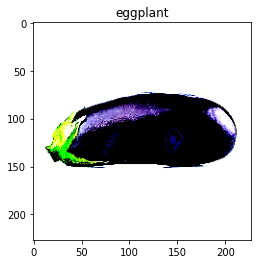

In [ ]:
image,label = trainset[0]

class_list = ['cucumber', 'eggplant', 'mushroom']
plt.imshow(image.permute(1,2,0))
plt.title(class_list[label]);

In [ ]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size= BATCH_SIZE)

In [ ]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [ ]:
for images , labels in trainloader:
    break
print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model 

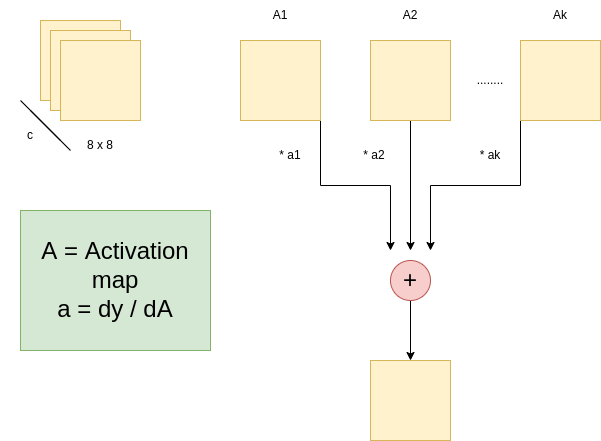

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
class ImageModel(nn.Module):
  def __init__(self):  
      super(ImageModel, self).__init__()

      self.feature_extractor= nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(4,4),stride=2),

          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(4,4),stride=2),

          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=(4,4),stride=2),

          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
          nn.ReLU(),
      )

      self.maxpool = nn.MaxPool2d(kernel_size=(4,4),stride=2)

      self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Linear(6400,2048),
          nn.ReLU(),
          nn.Linear(2048,3)
      )
      self.gradient = None

  def activations_hook(self, grad):
    self.gradient =grad

  def forward(self,images):
    x= self.feature_extractor(images)
    h= x.register_hook(self.activations_hook)
    x= self.maxpool(x)
    x= self.classifier(x)
    return x

  def get_activation_gradients(self):
    return self.gradient

  def get_activation(self,x):
    return self.feature_extractor(x)
     
    

In [ ]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [ ]:
def train_fn(dataloader,model,optimizer,criterion):
  model.train()
  total_loss=0.0
  for images, labels in tqdm(dataloader):
    images= images.to(DEVICE)
    labels= labels.to(DEVICE)

    optimizer.zero_grad()
    logits=model(images)
    loss=criterion(logits,labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)
  

In [ ]:
def eval_fn(dataloader,model,criterion):
  model.eval()
  total_loss=0.0
  for images, labels in tqdm(dataloader):
    images= images.to(DEVICE)
    labels= labels.to(DEVICE)

  
    logits=model(images)
    loss=criterion(logits,labels)
    
    

    total_loss += loss.item()
  return total_loss/len(dataloader)
  

# Training Loop

In [ ]:
optimizer= torch.optim.Adam(model.parameters(), lr=LR)
criterion= torch.nn.CrossEntropyLoss()

In [ ]:
best_valid_loss= np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer, criterion)
    valid_loss = eval_fn(validloader,model,criterion)

    if valid_loss< best_valid_loss:

      torch.save(model.state_dict(), 'best_weights.pt')
      best_valid_loss = valid_loss
      print(" Saves weights success")
    print(f"EPOCH: {1+i} TRAIN_LOSS: {train_loss} VALID_LOSS:{valid_loss}")


100%|██████████| 3/3 [00:00<00:00, 34.54it/s]


 Saves weights success
EPOCH: 1 TRAIN_LOSS: 1.289470636844635 VALID_LOSS:1.1036789814631145


100%|██████████| 3/3 [00:00<00:00, 34.68it/s]


 Saves weights success
EPOCH: 2 TRAIN_LOSS: 0.9962171316146851 VALID_LOSS:0.9275101025899252


100%|██████████| 3/3 [00:00<00:00, 34.58it/s]


 Saves weights success
EPOCH: 3 TRAIN_LOSS: 0.6750494778156281 VALID_LOSS:0.4950733780860901


100%|██████████| 3/3 [00:00<00:00, 35.70it/s]


 Saves weights success
EPOCH: 4 TRAIN_LOSS: 0.6786518186330796 VALID_LOSS:0.47878497838974


100%|██████████| 3/3 [00:00<00:00, 36.83it/s]


 Saves weights success
EPOCH: 5 TRAIN_LOSS: 0.46425621807575224 VALID_LOSS:0.41602174441019696


100%|██████████| 3/3 [00:00<00:00, 35.53it/s]


EPOCH: 6 TRAIN_LOSS: 0.4074442729353905 VALID_LOSS:0.44075992206732434


100%|██████████| 3/3 [00:00<00:00, 33.83it/s]


 Saves weights success
EPOCH: 7 TRAIN_LOSS: 0.2004917450249195 VALID_LOSS:0.21457736194133759


100%|██████████| 3/3 [00:00<00:00, 35.97it/s]


EPOCH: 8 TRAIN_LOSS: 0.28354302458465097 VALID_LOSS:0.31388826357821625


100%|██████████| 3/3 [00:00<00:00, 36.36it/s]


EPOCH: 9 TRAIN_LOSS: 0.44296348467469215 VALID_LOSS:0.2358271429936091


100%|██████████| 3/3 [00:00<00:00, 36.05it/s]


 Saves weights success
EPOCH: 10 TRAIN_LOSS: 0.14796157442033292 VALID_LOSS:0.13644527768095335


100%|██████████| 3/3 [00:00<00:00, 35.59it/s]


 Saves weights success
EPOCH: 11 TRAIN_LOSS: 0.0863424010691233 VALID_LOSS:0.07464281345407169


100%|██████████| 3/3 [00:00<00:00, 36.24it/s]


EPOCH: 12 TRAIN_LOSS: 0.07259587943553925 VALID_LOSS:0.2021762877702713


100%|██████████| 3/3 [00:00<00:00, 34.95it/s]


EPOCH: 13 TRAIN_LOSS: 0.04579328842228279 VALID_LOSS:0.18497827757770816


100%|██████████| 3/3 [00:00<00:00, 21.22it/s]


EPOCH: 14 TRAIN_LOSS: 0.057464534789323805 VALID_LOSS:0.19174071649710336


100%|██████████| 3/3 [00:00<00:00, 25.18it/s]


EPOCH: 15 TRAIN_LOSS: 0.023871895996853708 VALID_LOSS:0.11535248843332131


100%|██████████| 3/3 [00:00<00:00, 22.37it/s]


EPOCH: 16 TRAIN_LOSS: 0.0960831979115028 VALID_LOSS:0.13098258276780447


100%|██████████| 3/3 [00:00<00:00, 35.07it/s]


 Saves weights success
EPOCH: 17 TRAIN_LOSS: 0.2527339332271367 VALID_LOSS:0.07429133728146553


100%|██████████| 3/3 [00:00<00:00, 35.87it/s]


EPOCH: 18 TRAIN_LOSS: 0.11836217939853669 VALID_LOSS:0.3140212579940756


100%|██████████| 3/3 [00:00<00:00, 34.87it/s]


EPOCH: 19 TRAIN_LOSS: 0.12839803025126456 VALID_LOSS:0.279041846593221


100%|██████████| 3/3 [00:00<00:00, 36.23it/s]

EPOCH: 20 TRAIN_LOSS: 0.08713784198043868 VALID_LOSS:0.3933172921339671


# Get GradCAM

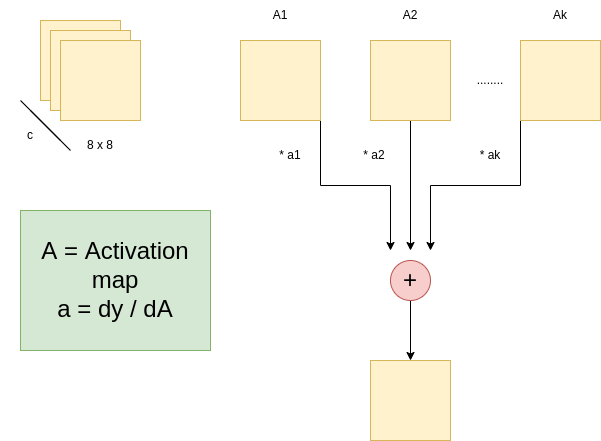

In [ ]:
def get_gradcam(model,image,label,size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim =[0,2,3])
  activations= model.get_activation(image).detach()

  for i in range(activations.shape[1]):
    activations[:,1,:,:] *= pooled_gradients[i]

  heatmap= torch.mean(activations, dim=1).squeeze().cpu()
  heatmap= nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(),(size,size))
  return heatmap

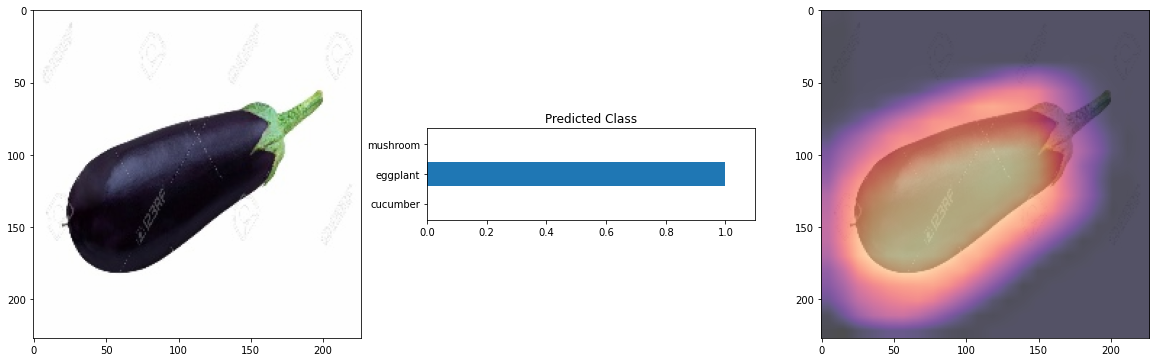

In [ ]:
image, label = validset[4]

denorm_image = image.permute(1,2,0)* np.array((0.229,0.224,0.225))+ np.array((0.485, 0.456,0.406))
image = image.unsqueeze(0).to(DEVICE)
pred= model(image)
heatmap= get_gradcam(model, image,pred[0][1], size= 227)
utils.plot_heatmap(denorm_image,pred,heatmap) 